## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss, mean_squared_error
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import SGD, Adam
import tensorflow_probability as tfp
tfd = tfp.distributions
from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import json
import logging

plt.ioff()

logger = logging.getLogger('thesis')
logging.basicConfig(level=logging.WARNING)

## Settings

In [2]:
optimizer = Adam(learning_rate=0.001)
batch_size = 64
train_size = 1000000
epochs = 1
verbosity = 1

## Target distribution

In [3]:
mix = 0.6
dist = tfd.Mixture(
	cat=tfd.Categorical(probs=[mix, 1. - mix]),
	components=[
		tfd.Normal(loc=-3., scale=1.),
		tfd.Normal(loc=+3., scale=0.5),
	]
)

## Generate data

In [4]:
def generate_data(n):
    x_train = tf.ones(n)
    y_train = dist.sample((n,))
    x_test = tf.ones(1)
    return x_train, y_train, x_test

x_train, y_train, x_test = generate_data(train_size)

## Plot data

In [5]:
def plot_data(axis):
    x = tf.linspace(-6., 6., 1000)
    axis.plot(x, dist.prob(x), label='Data distribution')
    axis.set_xlim([-6, 6])
    axis.set_ylim(bottom=0)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8), dpi=150)

## Mean squared error

In [6]:
def neuron(loss, output_size=1):
	model = Sequential([Dense(output_size, use_bias=False)])
	model.compile(loss=loss, optimizer=optimizer)
	return model

model = neuron(mean_squared_error)
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbosity)
pred = model.predict(x_test)[0]
print(pred)

15625/15625 [==============================] - 21s 1ms/step - loss: 9.7831
[-0.6042651]


In [7]:
axis = axes[0, 0]
plot_data(axis)
axis.axvline(pred, color='orange', label='Prediction')
axis.axvline(dist.mean(), color='g', label='Mean')
axis.legend(loc='upper left')
axis.set_title('Squared error')

Text(0.5, 1.0, 'Squared error')

## GPL Loss 

In [8]:
class MultiQuantileLoss(Loss):
	def __init__(self, quantiles):
		super().__init__()
		self.quantiles = np.array(quantiles)

	def call(self, obs, pred):
		diff = obs - pred
		mask = tf.where(diff < 0, 1., 0.)
		loss_per_quantile = diff * (self.quantiles[np.newaxis, :] - mask)
		return tf.reduce_mean(loss_per_quantile, axis=1)

In [9]:
quantiles = np.linspace(0.05, 0.95, 19)
model = neuron(MultiQuantileLoss(quantiles), output_size=len(quantiles))
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbosity)
preds = model.predict(x_test)[0]
print(preds)

15625/15625 [==============================] - 26s 2ms/step - loss: 0.9938
[-4.393569   -3.9658625  -3.6684859  -3.4223485  -3.2081194  -2.9988606
 -2.7913072  -2.5721207  -2.322784   -2.0244412  -1.6090181   0.27824304
  2.4282973   2.6701365   2.8486164   3.0104408   3.1693094   3.3480868
  3.5802236 ]


In [10]:
axis = axes[0, 1]
plot_data(axis)
for pred in preds:
    axis.axvline(pred, color='orange')
handles, labels = axis.get_legend_handles_labels()
handles.append(mpl.lines.Line2D([0], [0], color='orange', label='Prediction'))
axis.legend(handles=handles, loc='upper left')
axis.set_title('Quantile score')

cdf = dist.cdf(preds).numpy()
data = np.array([quantiles, preds, cdf])
data = np.moveaxis(data, 1, 0)
df = pd.DataFrame(data, columns=['quantiles', 'predictions', 'cdf']).set_index('quantiles').T
df

quantiles,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
predictions,-4.393569,-3.965863,-3.668486,-3.422348,-3.208119,-2.998861,-2.791307,-2.572121,-2.322784,-2.024441,-1.609018,0.278243,2.428297,2.670136,2.848616,3.010441,3.169309,3.348087,3.580224
cdf,0.049034,0.100234,0.151147,0.201831,0.250541,0.300273,0.349594,0.399378,0.450519,0.501215,0.550731,0.599687,0.650574,0.701886,0.752413,0.803332,0.853021,0.902736,0.950827


## NLL

In [11]:
def neuron_gaussian(loss, output_size=1):
	inp = Input(shape=[1])
	mean = Dense(output_size, use_bias=False)(inp)
	std = Dense(output_size, use_bias=False, activation='softplus')(inp)
	output = Concatenate()([mean, std])
	model = Model(inp, output)
	model.compile(loss=loss, optimizer=optimizer)
	return model

In [12]:
class GaussianNLL(Loss):
	def call(self, obs, pred):
		obs = obs[:, 0]
		pred_mean = pred[:, 0]
		pred_std = pred[:, 1]
		dist = tfp.distributions.Normal(loc=pred_mean, scale=pred_std)
		return K.sum(-dist.log_prob(obs))

In [13]:
model = neuron_gaussian(GaussianNLL())
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbosity)
pred_mean, pred_std = model.predict(x_test)[0]

15625/15625 [==============================] - 41s 3ms/step - loss: 239.2652


In [14]:
axis = axes[1, 0]
plot_data(axis)
pred_dist = tfd.Normal(loc=pred_mean, scale=pred_std)
x = np.linspace(-6, 6, 1000)
axis.plot(x, pred_dist.prob(x), label='Prediction')
axis.legend(loc='upper left')
axis.set_title('Log score')

Text(0.5, 1.0, 'Log score')

## Bimodal NLL

In [15]:
def neuron_gaussian_bimodal(loss, output_size=1):
	inp = Input(shape=[1])
	mean = Dense(2 * output_size, use_bias=False)(inp)
	std = Dense(2 * output_size, use_bias=False, activation='softplus')(inp)
	mix = Dense(1 * output_size, use_bias=False, activation='sigmoid')(inp)
	output = Concatenate()([mean, std, mix])
	model = Model(inp, output)
	model.compile(loss=loss, optimizer=optimizer)
	return model

In [16]:
class BiGaussianNLL(Loss):
    def call(self, obs, pred):
        obs = obs[:, 0]
        pred_mean1 = pred[:, 0]
        pred_mean2 = pred[:, 1]
        pred_std1 = pred[:, 2]
        pred_std2 = pred[:, 3]
        pred_mix = pred[:, 4]

        dist = tfd.Mixture(
            cat=tfd.Categorical(probs=tf.stack([pred_mix, 1. - pred_mix], axis=1)),
            components=[
                tfd.Normal(loc=pred_mean1, scale=pred_std1),
                tfd.Normal(loc=pred_mean2, scale=pred_std2),
            ]
        )
        return K.sum(-dist.log_prob(obs))

In [17]:
model = neuron_gaussian_bimodal(BiGaussianNLL())
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbosity)
pred_mean1, pred_mean2, pred_std1, pred_std2, pred_mix = model.predict(x_test)[0]

15625/15625 [==============================] - 79s 5ms/step - loss: 145.2541


In [18]:
axis = axes[1, 1]
plot_data(axis)
pred_dist = tfd.Mixture(
    cat=tfd.Categorical(probs=[pred_mix, np.float32(1.) - pred_mix]),
    components=[
        tfd.Normal(loc=pred_mean1, scale=pred_std1),
        tfd.Normal(loc=pred_mean2, scale=pred_std2),
])
x = np.linspace(-6, 6, 1000)
axis.plot(x, pred_dist.prob(x), label='Prediction')
axis.legend(loc='upper left')
axis.set_title('Log score')

print(pred_mean1, pred_mean2, pred_std1, pred_std2, pred_mix)

-3.0064406 2.9903076 0.99838233 0.4945907 0.59583795


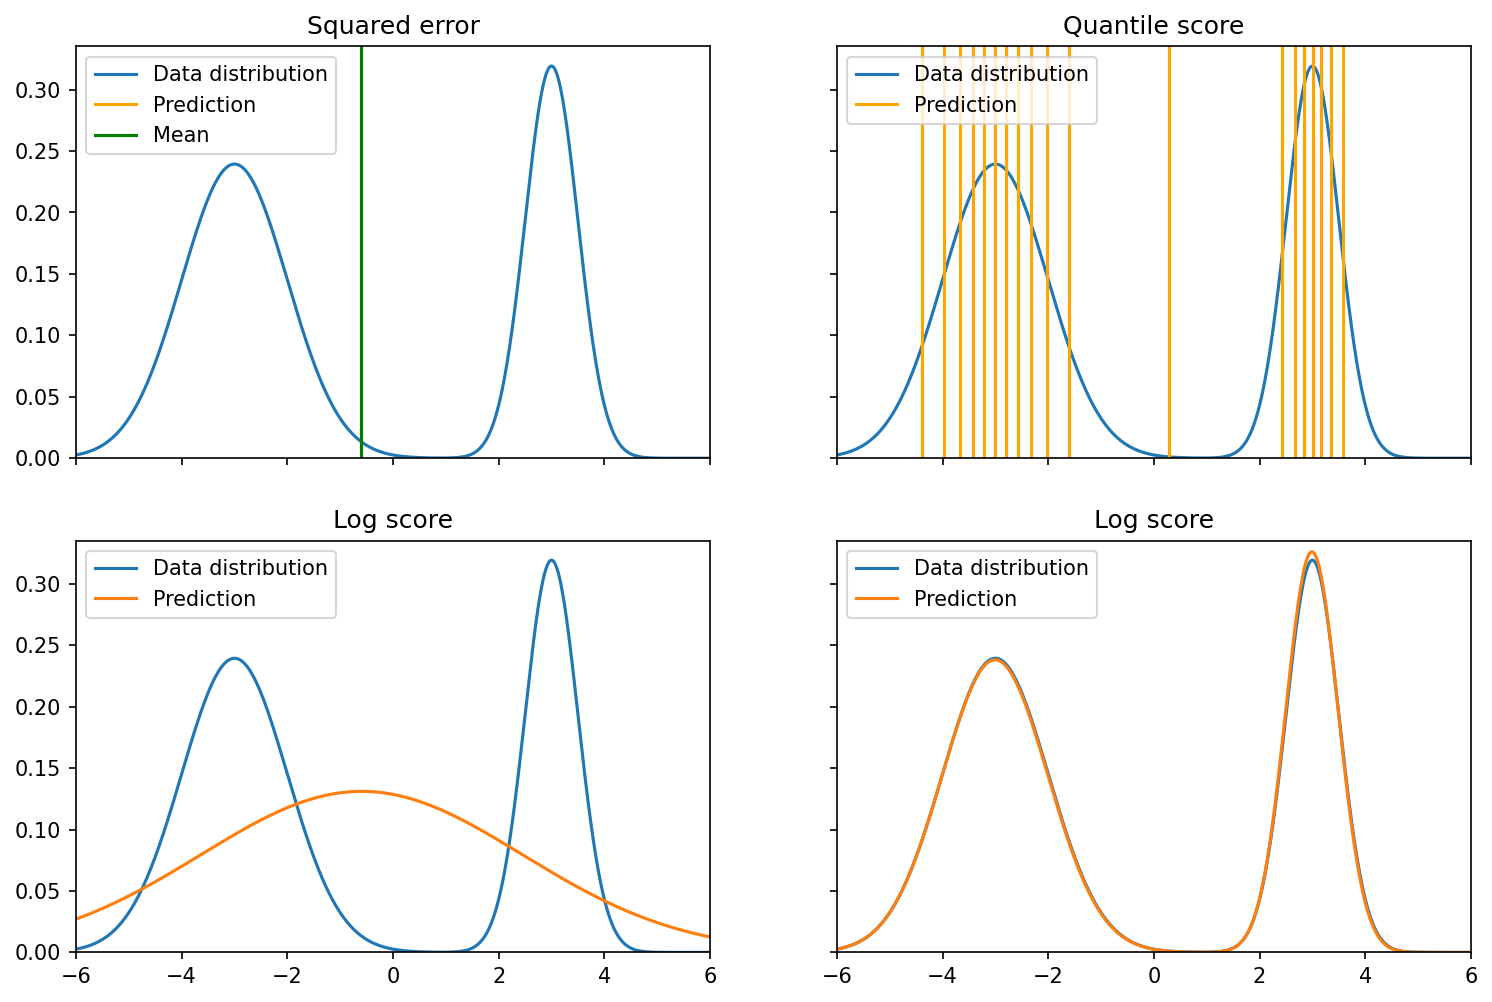

In [19]:
plt.show()